Classes (label encoding): {'Iris-setosa': np.int64(0), 'Iris-versicolor': np.int64(1), 'Iris-virginica': np.int64(2)}
Train/Val/Test sizes: 120 15 15

=== Classification metrics on test set (one-vs-rest linear regressor) ===
Accuracy: 0.7333
Precision - macro: 0.7460, micro: 0.7333, weighted: 0.7460
Recall    - macro: 0.7333, micro: 0.7333, weighted: 0.7333
F1-score  - macro: 0.7222, micro: 0.7333, weighted: 0.7222
Class 0 (Iris-setosa): precision=1.000, recall=1.000, f1=1.000, support=5
Class 1 (Iris-versicolor): precision=0.667, recall=0.400, f1=0.500, support=5
Class 2 (Iris-virginica): precision=0.571, recall=0.800, f1=0.667, support=5


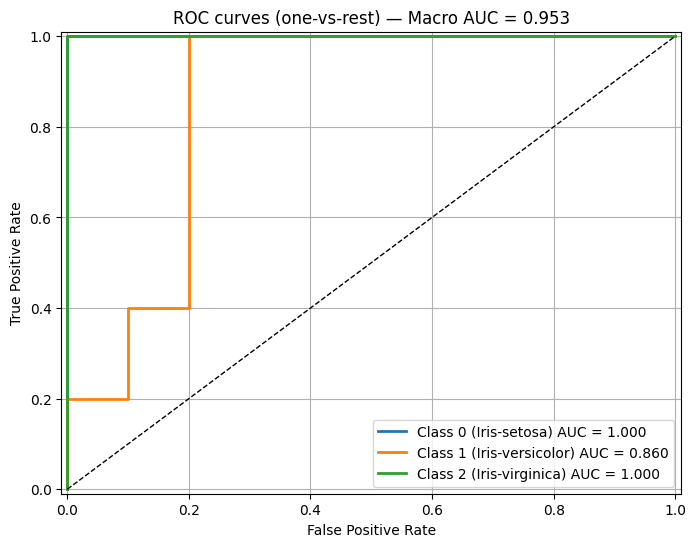


AUC per class: {'Iris-setosa': 1.0, 'Iris-versicolor': 0.8600000000000001, 'Iris-virginica': 1.0}
Macro AUC (avg of per-class AUCs): 0.9533

=== Linear regression (normal equation) predicting numeric labels ===
MAE: 0.161833
MSE: 0.035739
R2 : 0.946391

Test samples (true_label -> predicted_continuous):
0 -> 0.0244
1 -> 1.2167
1 -> 0.8443
1 -> 1.1792
2 -> 2.2142
0 -> -0.0175
0 -> -0.0810
2 -> 1.7917
2 -> 1.5805
1 -> 1.2639
2 -> 1.8562
0 -> -0.0750
0 -> -0.1469
1 -> 1.1791
2 -> 1.8977


In [9]:
# iris_metrics_and_roc.py
# ------------------------------------------------
# Requirements: numpy, pandas, scikit-learn, matplotlib
# Place Iris.csv in same folder (downloaded from Kaggle)
# ------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_curve, auc, mean_absolute_error,
    mean_squared_error, r2_score, precision_recall_fscore_support
)
from collections import defaultdict

# ---------------------------
# Helpers: Linear regression (normal equation) one-vs-rest
# ---------------------------
def fit_linear_regressor(X, y):
    # normal equation with pseudo-inverse for numerical stability
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    theta = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    return theta

def predict_scores(X, thetas):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    scores = np.vstack([X_b.dot(theta) for theta in thetas]).T
    return scores

def train_one_vs_rest(X, y, class_labels):
    thetas = []
    for c in class_labels:
        y_bin = (y == c).astype(float)
        theta = fit_linear_regressor(X, y_bin)
        thetas.append(theta)
    return np.array(thetas)

# ---------------------------
# Stratified equal per class split (80:10:10)
# ---------------------------
def stratified_equal_splits(df, label_col='label', proportions=(0.8, 0.1, 0.1), random_state=42):
    rng = np.random.default_rng(random_state)
    train_list, val_list, test_list = [], [], []
    for cls in sorted(df[label_col].unique()):
        sub = df[df[label_col]==cls].sample(frac=1, random_state=int(rng.integers(0,2**31-1))).reset_index(drop=True)
        n = len(sub)
        n_train = int(np.floor(proportions[0]*n))
        n_val   = int(np.floor(proportions[1]*n))
        n_test  = n - n_train - n_val
        train_list.append(sub.iloc[:n_train])
        val_list.append(sub.iloc[n_train:n_train+n_val])
        test_list.append(sub.iloc[n_train+n_val:])
    train_df = pd.concat(train_list).sample(frac=1, random_state=0).reset_index(drop=True)
    val_df   = pd.concat(val_list).sample(frac=1, random_state=0).reset_index(drop=True)
    test_df  = pd.concat(test_list).sample(frac=1, random_state=0).reset_index(drop=True)
    return train_df, val_df, test_df

# ---------------------------
# Load Iris Dataset
# ---------------------------
df = pd.read_csv("../lab5/Iris.csv")  # adjust path if needed
if 'Id' in df.columns:
    df = df.drop(columns=['Id'])
if 'Species' not in df.columns and 'species' in df.columns:
    df.rename(columns={'species':'Species'}, inplace=True)

le = LabelEncoder()
df['label'] = le.fit_transform(df['Species'])   # 0,1,2
features = [c for c in df.columns if c not in ('Species','label')]

# Split data
train_df, val_df, test_df = stratified_equal_splits(df, 'label', proportions=(0.8,0.1,0.1), random_state=42)
X_train = train_df[features].values; y_train = train_df['label'].values
X_val   = val_df[features].values;   y_val   = val_df['label'].values
X_test  = test_df[features].values;  y_test  = test_df['label'].values

class_labels = sorted(np.unique(y_train))
print("Classes (label encoding):", dict(zip(le.classes_, class_labels)))
print("Train/Val/Test sizes:", len(y_train), len(y_val), len(y_test))

# ---------------------------
# Train one-vs-rest linear regressors (classification via max score)
# ---------------------------
thetas = train_one_vs_rest(X_train, y_train, class_labels)
scores_test = predict_scores(X_test, thetas)   # shape (n_test, n_classes)
preds_test = np.argmax(scores_test, axis=1)

# ---------------------------
# Compute Classification Metrics
# ---------------------------
acc = accuracy_score(y_test, preds_test)
precision_macro = precision_score(y_test, preds_test, average='macro', zero_division=0)
recall_macro = recall_score(y_test, preds_test, average='macro', zero_division=0)
f1_macro = f1_score(y_test, preds_test, average='macro', zero_division=0)

precision_micro = precision_score(y_test, preds_test, average='micro', zero_division=0)
recall_micro = recall_score(y_test, preds_test, average='micro', zero_division=0)
f1_micro = f1_score(y_test, preds_test, average='micro', zero_division=0)

precision_weighted = precision_score(y_test, preds_test, average='weighted', zero_division=0)
recall_weighted = recall_score(y_test, preds_test, average='weighted', zero_division=0)
f1_weighted = f1_score(y_test, preds_test, average='weighted', zero_division=0)

print("\n=== Classification metrics on test set (one-vs-rest linear regressor) ===")
print(f"Accuracy: {acc:.4f}")
print(f"Precision - macro: {precision_macro:.4f}, micro: {precision_micro:.4f}, weighted: {precision_weighted:.4f}")
print(f"Recall    - macro: {recall_macro:.4f}, micro: {recall_micro:.4f}, weighted: {recall_weighted:.4f}")
print(f"F1-score  - macro: {f1_macro:.4f}, micro: {f1_micro:.4f}, weighted: {f1_weighted:.4f}")

# Per-class precision/recall/F1
pc, rc, f1s, supp = precision_recall_fscore_support(y_test, preds_test, labels=class_labels, zero_division=0)
for i,c in enumerate(class_labels):
    print(f"Class {c} ({le.inverse_transform([c])[0]}): precision={pc[i]:.3f}, recall={rc[i]:.3f}, f1={f1s[i]:.3f}, support={supp[i]}")

# ---------------------------
# ROC curves & AUC (one-vs-rest)
# ---------------------------
y_test_binarized = label_binarize(y_test, classes=class_labels)   # shape (n_test, n_classes)

plt.figure(figsize=(8,6))
aucs = []
for i, c in enumerate(class_labels):
    fpr, tpr, thresholds = roc_curve(y_test_binarized[:, i], scores_test[:, i])
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, label=f"Class {c} ({le.inverse_transform([c])[0]}) AUC = {roc_auc:.3f}")

macro_auc = np.mean(aucs)
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC curves (one-vs-rest) — Macro AUC = {macro_auc:.3f}")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("\nAUC per class:", {le.inverse_transform([c])[0]: aucs[i] for i,c in enumerate(class_labels)})
print(f"Macro AUC (avg of per-class AUCs): {macro_auc:.4f}")

# ---------------------------
# Part 3: Normal Equation Linear Regression predicting numeric label
# ---------------------------
y_train_numeric = y_train.astype(float)
theta_num = fit_linear_regressor(X_train, y_train_numeric)
Xb_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]
y_test_pred_cont = Xb_test.dot(theta_num)

mae = mean_absolute_error(y_test, y_test_pred_cont)
mse = mean_squared_error(y_test, y_test_pred_cont)
r2 = r2_score(y_test, y_test_pred_cont)

print("\n=== Linear regression (normal equation) predicting numeric labels ===")
print(f"MAE: {mae:.6f}")
print(f"MSE: {mse:.6f}")
print(f"R2 : {r2:.6f}")

print("\nTest samples (true_label -> predicted_continuous):")
for true, pred in zip(y_test, y_test_pred_cont):
    print(f"{true} -> {pred:.4f}")
